# EC HW4
**Stu. Name:** Mohammad Amin Dadgar

**Stu. Id:** 4003624016

First we'll import the requiered functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import json

In [2]:
from generate_population_scripts import (generate_population,
                                         evaluate_distance_fitness, 
                                         evaluate_fitness_customers_count,
                                         evaluate_fitness_customers_served_demands,
                                         evaluate_fitness_vehicle_count,
                                         find_depot_using,
                                         get_evalution_count, 
                                         set_evaluation_count,
                                         multi_objective_fitness_coeff, 
                                         multi_objective_fitness)
from combination import cut_and_crossfill, mutation_inverse, mutation_scramble
from selection import roulette_wheel, binary_tournament
from multi_objective_handelers import find_pareto_set

The whole algorithm as a function.

In [3]:
def algorithm_run(pop_count, 
                  dataset, 
                  depot_location_dict, 
                  vehicle_count, 
                  selection_method, 
                  FITNESS_FUNCTIONS, 
                  MUTATION_METHOD, 
                  RECOMBINATION_METHOD, 
                  max_capacity=None, 
                  max_distance=None, 
                  p_m=0.1,
                  p_c =0.9,
                  max_evaluations = 5000,
                  vehicle_depot_constraint=True,
                  all_customers=True,
                  multi_objective_handler='coeff'):
    """
    one constraint should be always given as input, the maximum capacity or maximum distance
    for the parameter `FITNESS_FUNCTIONS` if it was a list of fitness functions, then we would assume the problem as multi-objective problem else it is a single objective problem
    
    multi_objective handler can be using coefficients or an algorithm like NSGA-II in which pareto-set is calculated
    """
    ## reset the evaluation counts
    set_evaluation_count(0)
    
    population, fitness_pop = generate_population(max_capacity=max_capacity,
                                                     max_distance=max_distance,
                                                     depot_location_dict= depot_location_dict,
                                                     dataset=dataset, 
                                                     pop_count= pop_count,
                                                     vehicle_count= vehicle_count, 
                                                     fitness_functions = FITNESS_FUNCTIONS, 
                                                     vehicle_depot_constraint = vehicle_depot_constraint,
                                                     all_customers=all_customers, 
                                                     multi_objective_handler = multi_objective_handler)
    generation_count = 0

    best_chromosome = None
    best_chromsome_fitness = None

    while get_evalution_count() < max_evaluations:
        print(f'Generation Count: {generation_count}, Evaluations number: {get_evalution_count()}')
        
        ## saving the results
        np.savetxt(os.path.join('results', f'population_gen{generation_count}_method={multi_objective_handler}.csv'), population, delimiter=',', fmt='%s')
        np.savetxt(os.path.join('results', f'fitness_pop_gen{generation_count}_method={multi_objective_handler}.csv'), fitness_pop, delimiter=',',fmt='%s')
        
        ## create pair of the parents
        parent_pairs = []
        for _ in range(pop_count):
            pair = selection_method(population, fitness_pop)
            parent_pairs.append(pair)

        
        offsprings = []
        fitness_offsprings = []
        for parents in parent_pairs:
            recombination_p = np.random.random()

            ## the offspring for this iteration
            iteration_offspring = []
            
            ######## Recombination ########
            if recombination_p < p_c:
                offspring1, offspring2 =  RECOMBINATION_METHOD(parents[0], parents[1], dataset, max_capacity, max_distance, depot_location_dict, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]

            
            ######## Mutation ########
            mutation_p = np.random.random()

            ## if cross over has happend
            if len(iteration_offspring) != 0 and mutation_p < p_m:
                offspring1 = MUTATION_METHOD(iteration_offspring[0], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)
                offspring2 = MUTATION_METHOD(iteration_offspring[1], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]
            ## if cross over had not happened
            elif mutation_p < p_m:
                offspring1 = MUTATION_METHOD(parents[0], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)
                offspring2 = MUTATION_METHOD(parents[1], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]
            ## if both cross over and mutation has not happened!
            else:
                iteration_offspring = [parents[0], parents[1]]
            
            ## if no offspring was produced
            if iteration_offspring[0] == '':
                iteration_offspring[0] = parents[0]
            elif iteration_offspring[1] == '':
                iteration_offspring[1] = parents[1]
            else:
                iteration_offspring[0] = parents[0]
                iteration_offspring[1] = parents[1]
                
            ## finally append the genarated offsprings to offspring array 
            offsprings.append(iteration_offspring[0])
            offsprings.append(iteration_offspring[1])
            
            depot_symbol = find_depot_using(iteration_offspring[0], list(depot_location_dict.keys()))
            depot_symbol2 = find_depot_using(iteration_offspring[1], list(depot_location_dict.keys()))

            ## if the problem was single objective
            if type(FITNESS_FUNCTIONS) is not list:
                fitness_offsprings.append(FITNESS_FUNCTIONS(iteration_offspring[0], depot_location_dict[depot_symbol], dataset))
                fitness_offsprings.append(FITNESS_FUNCTIONS(iteration_offspring[1], depot_location_dict[depot_symbol2], dataset))
            ## else it was multi-objective
            else:
                if multi_objective_handler == 'coeff':
                    fitness_offsprings.append(multi_objective_fitness_coeff(FITNESS_FUNCTIONS, iteration_offspring[0], depot_location_dict[depot_symbol], dataset))
                    fitness_offsprings.append(multi_objective_fitness_coeff(FITNESS_FUNCTIONS, iteration_offspring[1], depot_location_dict[depot_symbol2], dataset))
                else:
                    fitness_offsprings.append(multi_objective_fitness(FITNESS_FUNCTIONS, iteration_offspring[0], depot_location_dict[depot_symbol], dataset))
                    fitness_offsprings.append(multi_objective_fitness(FITNESS_FUNCTIONS, iteration_offspring[1], depot_location_dict[depot_symbol2], dataset))

        ## replace the old population with the new ones

        ## the whole generation: parents + offsprings
        generation_population = population.copy()
        generation_population.extend(offsprings)

        ## whole generation fitness: parents fitness + offsprings fitness
        generation_fitness = fitness_pop.copy()
        generation_fitness.extend(fitness_offsprings)

        ## if the problem was single objective
        ## or the fitnesses was combined using coefficients
        if type(FITNESS_FUNCTIONS) is not list or multi_objective_handler == 'coeff':        
            ## the sorted generation
            generation_population_sorted = np.array(generation_population)[np.argsort(generation_fitness)]
            generation_fitness_sorted = np.sort(generation_fitness)

            ## extract the best of the new generation
            best_of_generation_population = generation_population_sorted[:pop_count]
            best_of_generation_fitness = generation_fitness_sorted[:pop_count]

            best_chromosome = generation_population_sorted[0]
            best_chromsome_fitness = generation_fitness_sorted[0]
        else:
            ## the pareto-set as the sorted generation
            ## pareto front is the chromosomes itself
            ## and pareto_optimal is the fitness values
            generation_pareto_front, generation_pareto_optimal, other_generation, other_generation_fitness = find_pareto_set(np.array(generation_population), 
                                                                                                                             np.array(generation_fitness))
            ## if we got to the last generation, then end the loop and return just what we had in pareto-set
            if get_evalution_count() >= max_evaluations:
                best_chromosome, best_chromsome_fitness = generation_pareto_front, generation_pareto_optimal
                best_of_generation_population, best_of_generation_fitness = generation_pareto_front, generation_pareto_optimal
                continue
            
            ## if pareto_set was smaller than the pop_count
            ## then add other chromosomes into it
            if len(generation_pareto_front) < pop_count:
                best_of_generation_population = generation_pareto_front.copy()
                best_of_generation_population = np.append(best_of_generation_population, other_generation[:pop_count - len(generation_pareto_front)], 0)
                
                best_of_generation_fitness = generation_pareto_optimal.copy()

                best_of_generation_fitness = np.append(best_of_generation_fitness, other_generation_fitness[:pop_count - len(generation_pareto_front)], 0)

            else:
                ## else if the pareto-set length was more than population needed, then get the part of it
                best_of_generation_population = generation_pareto_front[:pop_count]
                best_of_generation_fitness = generation_pareto_optimal[:pop_count]
        
        ## save them into the original population arrays
        population = best_of_generation_population.tolist()
        fitness_pop = best_of_generation_fitness.tolist()
        

        ## increase the generation value
        generation_count += 1
    
    return best_chromosome, best_chromsome_fitness

def plot_result(dataset, vehicle_solution, depot_locations_dict, legend=True):
    """
    plot from the locations vehicles start and end their service
    the vehicle_solution is a chromsome as the shown in each part
    
    depot_locations_dict is the dictionary representing different depot locations available on the map
    """
    plt.figure(figsize=(15,10))
    for vehicle_number, vehicle in enumerate(vehicle_solution.split('|')):
        locations_x_served = []
        locations_y_served = []
        for idx in range(3, len(vehicle) + 1, 3):
            symbol = vehicle[idx-3: idx]
            ## if it was a repository
            if re.match('\(\d+\)', symbol):
                locations_x_served.append(depot_locations_dict[symbol][0])
                locations_y_served.append(depot_locations_dict[symbol][1])                
            else:
                customer_num = (int(symbol) - 100)
                customer = dataset[dataset.number == customer_num]
                loc_x, loc_y = customer.x.values[0], customer.y.values[0]
                locations_x_served.append(loc_x)
                locations_y_served.append(loc_y)
                plt.text(loc_x, loc_y, s=f'{customer_num}')
        plt.plot(locations_x_served, locations_y_served, label=f'vehicle number:{vehicle_number}', marker='^', linestyle='--', alpha=0.5, zorder=-1)
    
    ## ploting the depositories
    markers = ['+', 'x', 'P', '1', '2']
    for idx, depot_symbol in enumerate(depot_locations_dict.keys()):
        plt.scatter(depot_locations_dict[depot_symbol][0], depot_locations_dict[depot_symbol][1], marker=markers[idx % 6], c='k', label=f'Depot: {depot_symbol}', zorder=1)
    if legend:
        plt.legend()


## Method 1 for multi-objective handling
In method 1, we just combined the objective functions with 1 or -1 coefficients. In the questions it was said that no function has a priority on another so we chosed 1.

### Problem No. 1
Problem description is written below
- There are 3 depot in the location `(31, 6)`, `(-31, 7)`, `(25, -10)`.
- There are `5` vehicles
- Maximum Capacity is `100`
- The locations of the customers and their demands are in `P1-2.txt` file
- The distance each vehicle can go is not limited.
- Two fitness functions: (1) Minimizing distance and (2) Maximizing *served customers* count

In [4]:
p1_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem1_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [6]:
problem1_best_chromsome, problem1_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=5 - 1, 
                selection_method=binary_tournament,
                FITNESS_FUNCTIONS=[evaluate_distance_fitness, evaluate_fitness_customers_count],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000)


problem1_best_chromsome, problem1_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(3)177120210105(3)|(3)217148136200129(3)118151145106(3)|(3)232211179117(3)143199246125156154(3)|(3)188158237(3)201196223114204224(3)176116187122144(3)138197178174249132(3)137113247215(3)212244180167(3)135141107123173(3)|(3)172248(3)205236157240(3)139102168(3)243250193185128166(3)|(3)202155149163(3)134165130164230124(3)186221182103229140(3)225150191245(3)195241222231146(3)104189216111(3)235160220(3)239192133161109(3)126206228(3)227183153(3)175181194152(3)171214110184198115(3)203207213226108(3)209219233242112(3)170121127119(3)169190131101142(3)208234159(3)218238162147(3)',
 1.2101888849782267)

In [7]:
## save results
with open(os.path.join('results', 'problem1_chromosome.txt'), 'w') as file:
    file.write(problem1_best_chromsome)

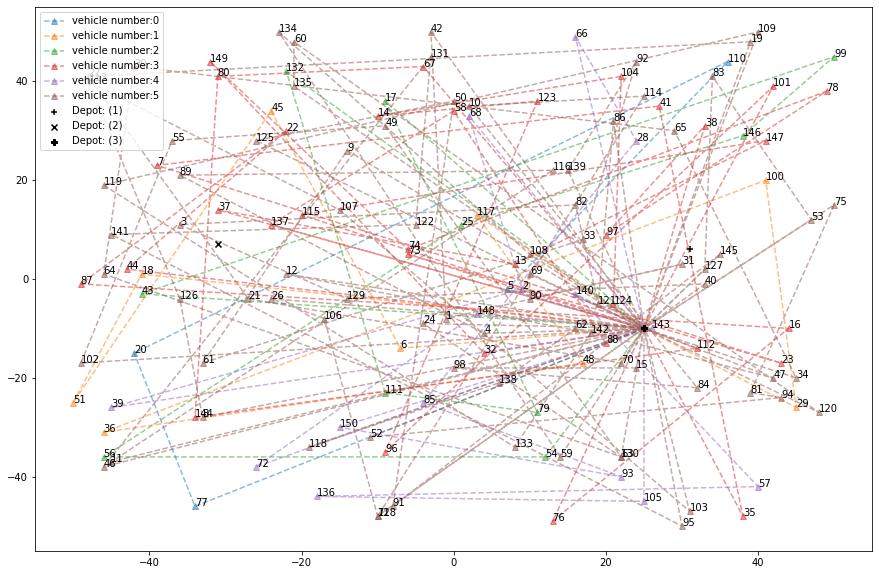

In [11]:
plot_result(p1_data, problem1_best_chromsome, DEPOT_LOCATIONS_dict)

In [9]:
chromosome = '(3)177120210105(3)|(3)217148136200129(3)118151145106(3)|(3)232211179117(3)143199246125156154(3)|(3)188158237(3)201196223114204224(3)176116187122144(3)138197178174249132(3)137113247215(3)212244180167(3)135141107123173(3)|(3)172248(3)205236157240(3)139102168(3)243250193185128166(3)|(3)202155149163(3)134165130164230124(3)186221182103229140(3)225150191245(3)195241222231146(3)104189216111(3)235160220(3)239192133161109(3)126206228(3)227183153(3)175181194152(3)171214110184198115(3)203207213226108(3)209219233242112(3)170121127119(3)169190131101142(3)208234159(3)218238162147(3)'
evaluate_distance_fitness(chromosome, 
                          DEPOT_LOCATION = DEPOT_LOCATIONS_dict['(3)'], 
                          dataset=p1_data, 
                          normalize=False)

10894

In [ ]:
evaluate_fitness_customers_count(chromosome, 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p1_data,
                                original=True)

### Problem No. 2
Problem description is written below
- There are 3 depot in the location `(31, 6)`, `(-31, 7)`, `(25, -10)`.
- There are `5` vehicles
- Maximum Capacity is `100`
- The locations of the customers and their demands are in `P1-2.txt` file
- The distance each vehicle can go is not limited.
- Two fitness functions: (1) Minimizing distance and (2) Maximizing *served customer demands* count

In [10]:
p2_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem2_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [13]:
problem2_best_chromsome, problem2_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=5 - 1, 
                selection_method=binary_tournament,
                FITNESS_FUNCTIONS=[evaluate_distance_fitness, evaluate_fitness_customers_served_demands],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000)


problem2_best_chromsome, problem2_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(3)171149228161185(3)206102(3)241112130221177104124242(3)120140166175196(3)|(3)210244192239133(3)202170215167200131(3)146217115176240(3)220150180122(3)190158117107(3)|(3)142225229218214173(3)156188182186(3)153226103139249(3)165118208116(3)141197245243128232(3)126211187135105108(3)183199109224(3)113174236164(3)213160127230(3)|(3)193233169129(3)157137191246(3)159147154(3)212207216237231(3)152134145155178(3)203101162247223(3)151179172(3)119204144(3)219121111(3)|(3)106234235250(3)123248114(3)195132222227(3)189181205143184(3)238136138194(3)110148168198(3)209125201163(3)',
 1.2474427353356583)

In [14]:
## save results
with open(os.path.join('results', 'problem2_chromosome.txt'), 'w') as file:
    file.write(problem2_best_chromsome)

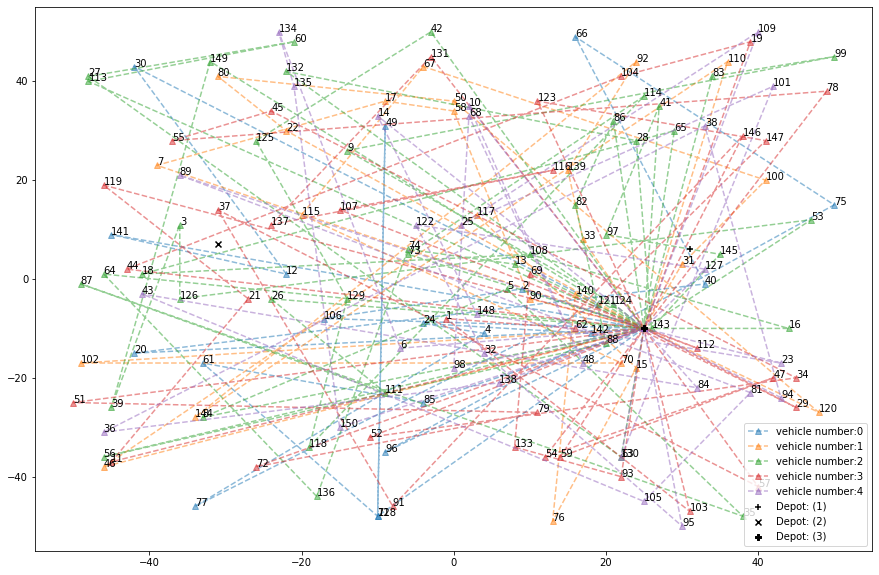

In [15]:
plot_result(p2_data, problem2_best_chromsome, DEPOT_LOCATIONS_dict)

In [12]:
chromosome = '(3)171149228161185(3)206102(3)241112130221177104124242(3)120140166175196(3)|(3)210244192239133(3)202170215167200131(3)146217115176240(3)220150180122(3)190158117107(3)|(3)142225229218214173(3)156188182186(3)153226103139249(3)165118208116(3)141197245243128232(3)126211187135105108(3)183199109224(3)113174236164(3)213160127230(3)|(3)193233169129(3)157137191246(3)159147154(3)212207216237231(3)152134145155178(3)203101162247223(3)151179172(3)119204144(3)219121111(3)|(3)106234235250(3)123248114(3)195132222227(3)189181205143184(3)238136138194(3)110148168198(3)209125201163(3)'
evaluate_distance_fitness(chromosome,
                          DEPOT_LOCATIONS_dict['(3)'],
                          p2_data,
                          normalize = False
                         )

10958

In [ ]:
evaluate_fitness_customers_served_demands(chromosome, 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p2_data,
                                original=True)

### Problem No. 3
Problem description is written below
- There are 3 depot in the location `(31, 6)`, `(-31, 7)`, `(25, -10)`.
- Maximum distace each vehicle can go is `200` Km
- The capacity is not limited for vehicles
- The locations of the customers and their demands are in `P3.txt` file
- Two fitness functions: (1) Minimizing vehicles count and (2) Maximizing *served customer demands* count

In [4]:
p3_data = pd.read_csv('data/P3.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (40, 23),
    '(2)': (0, 0),
    '(3)': (-18, -27)
}
with open(os.path.join('results', 'problem3_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [ ]:
problem3_best_chromsome, problem3_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p3_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=200,
                vehicle_count=None, 
                selection_method=roulette_wheel,
                FITNESS_FUNCTIONS = [evaluate_fitness_vehicle_count, evaluate_fitness_customers_served_demands],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000,
                all_customers=False)

problem3_best_chromsome, problem3_best_chromsome_fitness

In [6]:
## save results
with open(os.path.join('results', 'problem3_chromosome.txt'), 'w') as file:
    file.write(problem3_best_chromsome)

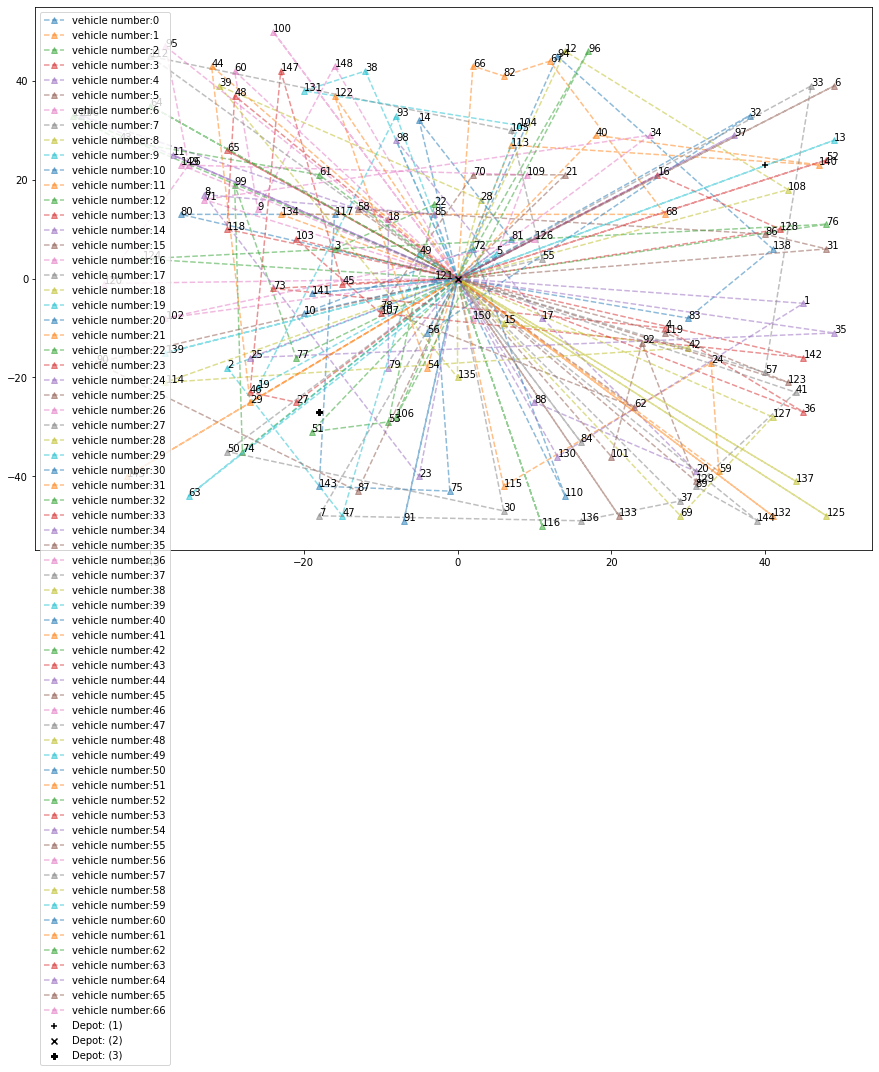

In [7]:
plot_result(p3_data, problem3_best_chromsome, DEPOT_LOCATIONS_dict)

In [14]:
chromosome = '(2)221175243217180(2)|(2)234168167182166(2)|(2)103122153151(2)|(2)127146247145(2)|(2)188120117198(2)|(2)121170178162(2)|(2)248109160(2)|(2)212205155(2)|(2)235139128(2)|(2)149147102(2)|(2)110172210(2)|(2)213240140(2)|(2)174199177(2)|(2)242207203(2)|(2)246118179(2)|(2)229192201(2)|(2)220126195(2)|(2)107236137(2)|(2)214142115(2)|(2)138231204(2)|(2)183238194(2)|(2)215124159(2)|(2)211143161(2)|(2)136104173(2)|(2)123108185(2)|(2)131186158(2)|(2)250209249(2)|(2)244189141(2)|(2)169227(2)|(2)193119(2)|(2)114181(2)|(2)129144(2)|(2)224176(2)|(2)116228(2)|(2)230101(2)|(2)223219(2)|(2)171134(2)|(2)130150(2)|(2)112208(2)|(2)163105(2)|(2)132156(2)|(2)222154(2)|(2)196206(2)|(2)218148(2)|(2)135125(2)|(2)190187(2)|(2)226202(2)|(2)157133(2)|(2)225(2)|(2)239(2)|(2)191(2)|(2)232(2)|(2)216(2)|(2)165(2)|(2)197(2)|(2)233(2)|(2)200(2)|(2)184(2)|(2)237(2)|(2)113(2)|(2)241(2)|(2)245(2)|(2)164(2)|(2)152(2)|(2)111(2)|(2)106(2)|(2)'
## vehicle count
chromosome.count('|')

66

In [ ]:
## maximizing customers demans
evaluate_fitness_customers_served_demands(chromosome, 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p3_data,
                                original=True)

## Method 2 for multi-objective handling
In this method we used to calculate the pareto-set and chosed the member of pareto set for survival.

### Problem 1

In [4]:
p1_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem1_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [6]:
problem1_best_chromsome, problem1_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=5, 
                selection_method=roulette_wheel,
                FITNESS_FUNCTIONS=[evaluate_distance_fitness, evaluate_fitness_customers_count],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000, 
                multi_objective_handler='nsga',
                all_customers=False)

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

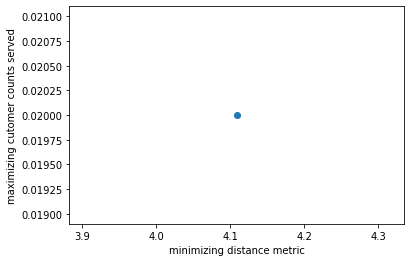

In [7]:
plt.scatter(problem1_best_chromsome_fitness[:, 0], problem1_best_chromsome_fitness[:, 1])
plt.ylabel('maximizing cutomer counts served')
plt.xlabel('minimizing distance metric')
plt.show()

In [8]:
evaluate_distance_fitness(problem1_best_chromsome[0], DEPOT_LOCATIONS_dict['(3)'], p1_data, normalize=False)

3444

In [9]:
evaluate_fitness_customers_count(problem1_best_chromsome[0], DEPOT_LOCATIONS_dict['(3)'], p1_data, normalize=False)

50.0

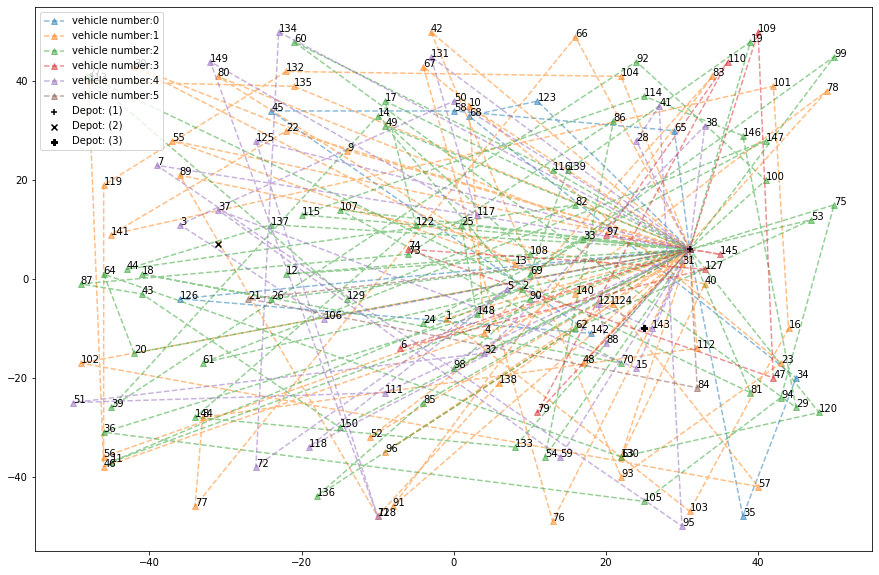

In [7]:
plot_result(p1_data, problem1_best_chromsome[0], DEPOT_LOCATIONS_dict)

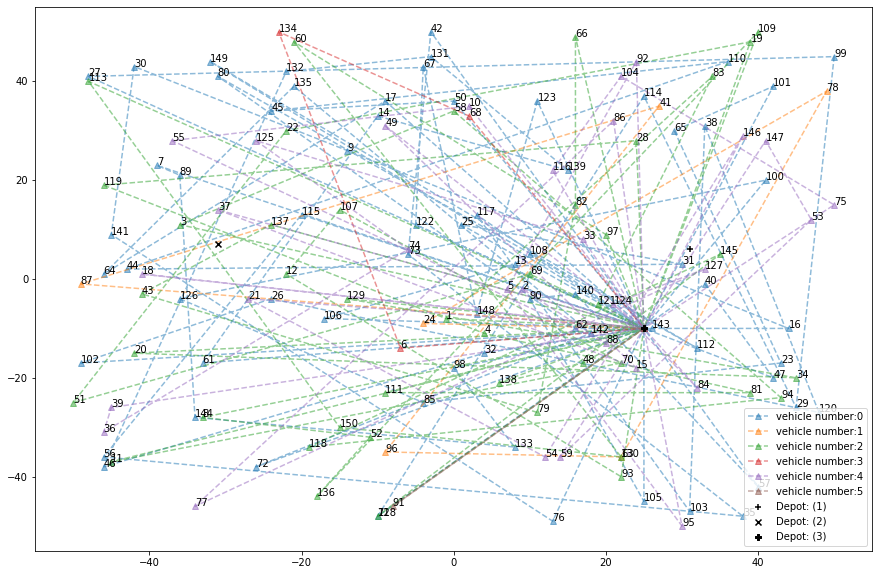

In [14]:
plot_result(p1_data, problem1_best_chromsome[1], DEPOT_LOCATIONS_dict)

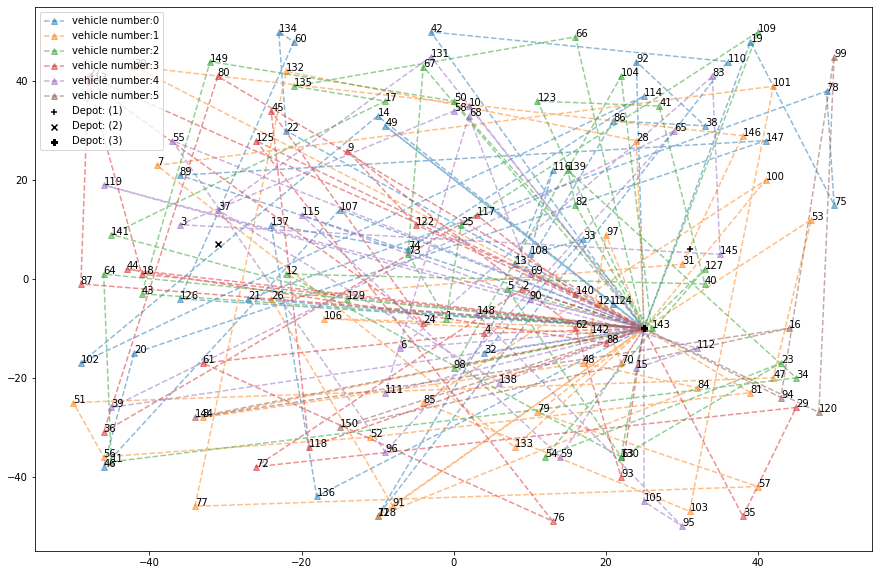

In [15]:
plot_result(p1_data, problem1_best_chromsome[2], DEPOT_LOCATIONS_dict)

### Problem 2

In [13]:
p2_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem2_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [14]:
problem2_best_chromsome, problem2_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=5, 
                selection_method=binary_tournament,
                FITNESS_FUNCTIONS=[evaluate_distance_fitness, evaluate_fitness_customers_served_demands],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000,
                multi_objective_handler='nsga')

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

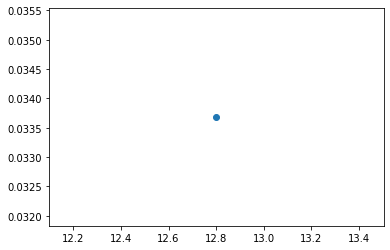

In [15]:
plt.scatter(problem2_best_chromsome_fitness[:, 0], problem2_best_chromsome_fitness[:, 1])

In [16]:
problem2_best_chromsome_fitness

array([[1.30899547e+00, 3.36813742e-04]])

In [22]:
## the distance gone
evaluate_distance_fitness(problem2_best_chromsome[0],
                          DEPOT_LOCATIONS_dict['(3)'],
                          p2_data,
                          normalize = False
                         )

10730

In [23]:
## customers served
evaluate_fitness_customers_served_demands(problem2_best_chromsome[0], 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p2_data,
                                normalize=False)

2969

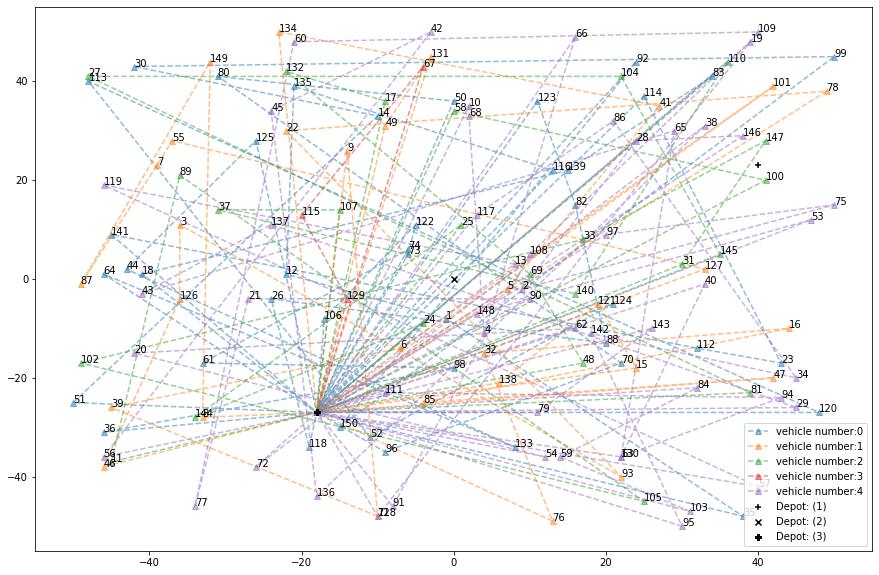

In [34]:
plot_result(p2_data, problem2_best_chromsome[0], DEPOT_LOCATIONS_dict)

### Problem 3

In [20]:
p3_data = pd.read_csv('data/P3.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (40, 23),
    '(2)': (0, 0),
    '(3)': (-18, -27)
}
with open(os.path.join('results', 'problem3_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [21]:
problem3_best_chromsome, problem3_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p3_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=200,
                vehicle_count=None, 
                selection_method=binary_tournament,
                FITNESS_FUNCTIONS = [evaluate_fitness_vehicle_count, evaluate_fitness_customers_served_demands],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000,
                all_customers=False,
                multi_objective_handler='nsga')

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

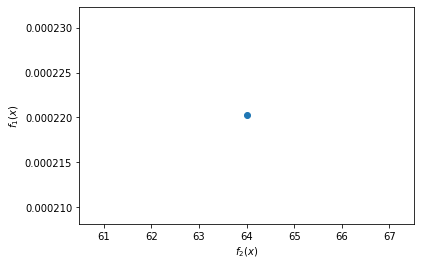

In [22]:
plt.scatter(problem3_best_chromsome_fitness[:, 0], problem3_best_chromsome_fitness[:, 1])
plt.ylabel('$f_1(x)$')
plt.xlabel('$f_2(x)$')
plt.show()

In [26]:
problem3_best_chromsome_fitness

array([[6.40000000e+01, 2.20215811e-04]])

In [24]:
## minimizing the vehicle count
problem3_best_chromsome[0].count('|')

63

In [25]:
## maximizing customers demans
evaluate_fitness_customers_served_demands(problem3_best_chromsome[0], 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p3_data,
                                original=True)

4541

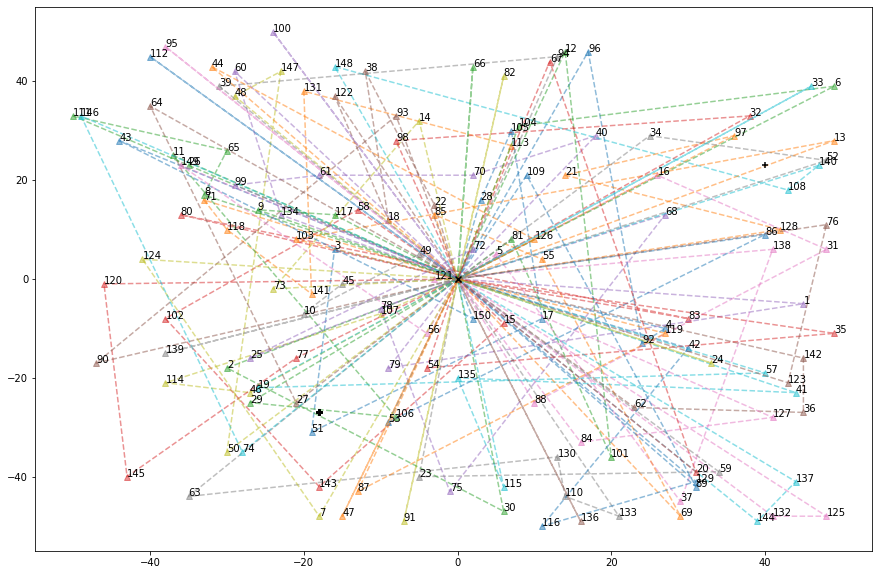

In [37]:
plot_result(p3_data, problem3_best_chromsome[0], DEPOT_LOCATIONS_dict, legend=False)

## Pymoo implementation
### Problem 1
Let's first formulate the problem
\begin{equation}
f_1(x) = \text{The total distance the vehicle gone.} \\
f_2(x) = \text{The count of customers served.}
\end{equation}

In [11]:
!python pymoo_trial.py --datasetname=data/P1-2.txt --problem_no=1

5942

### Problem 2

In [ ]:
!python pymoo_trial.py --datasetname=data/P1-2.txt --problem_no=2

### Problem 3

In [ ]:
!python pymoo_trial.py --datasetname=data/P3.txt --problem_no=3